## ¿Qué problema se va a resolver?
El tema de investigación surgió por la necesidad que tienen las empresas operadoras de taxis de la ciudad de Bogotá, estas vienen presentando una creciente problemática de indisponibilidad de servicios de taxis en sus plataformas, esto ocurre principalmente en algunas zonas u horarios específicos.
La empresa Taxis Libres (TL), una de las más grandes operadoras de servicios de taxis de la ciudad, ha empezado a recibir una gran cantidad de inconformidades por partes de los usuarios recurrentes de la plataforma por esta misma causa. Solo en el mes de mayo del 2022 la plataforma recibió alrededor de 1.2 millones de solicitudes de servicios de taxis de los cuales el 57% de esas solicitudes fueron abandonadas o rechazadas, lo que los llevó a analizar qué estaba pasando con la prestación de servicios internamente, en esa revisión realizada durante el mismo periodo de tiempo se obtuvieron las principales causas reportadas en la plataforma y que se listarán a continuación:

•	El usuario se fue

•	El vehículo se demoró en llegar

•	El usuario tomó otro taxi

Al identificar las causas de los servicios abandonados y rechazados, la empresa se planteó a resolver la siguiente pregunta al problema presentado.
¿Como reducir la alta cantidad de inconformidades de los usuarios recurrentes de la plataforma prediciendo sus comportamientos durante la semana y así programarles sus servicios de forma anticipada?

## Objetivo general
Diseñar un método para predecir las solicitudes de servicios de los usuarios recurrentes "de empresas de servicios de" taxis en la ciudad Bogotá - Colombia, "mediante" modelos de ML.


Evaluar el desempeño de modelos de ML para predecir
las solicitudes de servicios de los usuarios recurrentes de empresas de servicios de taxis en la ciudad Bogotá -  Colombia
basados en el comportamiento dentro de la plataforma.

## Objetivos específicos (Detallar las actividades)
• Revisar la literatura(pendiente)

• Analizar los datos de las BD de taxis libres necesarios.

• Determinar las variables significativas a ser empleadas en los modelos de ML.

• Evaluar diferentes modelos de ML para la predicción de solicitudes.

## ¿Que solución propone al problema?
El diseño de un modelo predictivo de solicitudes de servicios de taxis basados en comportamientos de usuarios recurrentes de plataformas móviles para empresas de transporte

## ¿Cómo lo pretende solucionar?
Utilizando un modelo de clasificación donde se agrupe la información de los servicios que han tomado los usuarios por días de las semanas y horarios, determinando si en ese día y a esa hora se va a tomar un servicio.

## ¿Que resultados que espera obtener?
Se espera obtener listado por día de las semanas con todos los horarios del día y un determinador que indique si el servicio se va a tomar o no en ese horario. 

### ANALISIS EXPLORATORIO DE DATOS

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Definición de librerías del proyecto

In [2]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import numpy as np
from numpy import NaN
from datetime import date, datetime, timedelta
from os import name


Definición de parámetros iniciales

In [3]:
NUM_OF_WEEK = 8.0
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'
DATE_START_TRAINIG = pd.to_datetime("2022-04-13", format=FORMAT_DATE)
FICHERO_DATA = './data/SERVICIO_UNIFICADO_2022.parquet.gzip'

Se cargan los datos en el dataFrame

In [4]:
#Se lee el archivo de un parquet a un dataframe
df_taxis = pd.read_parquet(FICHERO_DATA) 
#Se visualizan los datos
df_taxis.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19


Se valida cuantos valores nulos tenemos en el dataset

In [5]:
#Contar cuantos datos se encuentran nulos
df_taxis.isnull().sum()

ID                       0
IDCIUDAD                 0
USUARIO               1707
TELEFONOORIGEN       69322
LATITUD                  0
LATITUDDESTINO     1932690
LONGITUD                 0
LONGITUDDESTINO    1932690
ESTADO                   0
ORIGEN                   0
FECHACOMPLETA            0
DIADESEMANA              0
HORA                     0
dtype: int64

Se limpian los datos donde el teléfono del usuario es nulo
 para tener usuarios validos

In [6]:
#Se eliminan los registros donde el teléfono de origen sea nulo
df_taxis = df_taxis[~df_taxis['TELEFONOORIGEN'].isnull()]

Se limitan los datos a la ciudad de bogotá

In [7]:
#Se filtra el dataset solo para la ciudad de bogotá
df_taxis = df_taxis[df_taxis["IDCIUDAD"]==11001]

Se limitan los canales por donde se reciben servicios a APP, IVR, CHATBOT, RECEPCIÓN, CALLE Y WEB que son los más relevantes.

In [8]:
df_taxis = df_taxis[(df_taxis["ORIGEN"]=="APP") | (df_taxis["ORIGEN"]=="IVR") | (df_taxis["ORIGEN"]=="CHAT_BOT_659") | (df_taxis["ORIGEN"]=="RECEPCION") | (df_taxis["ORIGEN"]=="CALLE") | (df_taxis["ORIGEN"]=="WEB")]

Se limitan los estados a ABANDONADO, CUMPLIDO, CANCELADO Y FINALIZADO que son los validos, el restos son errores del proceso.

In [9]:
df_taxis = df_taxis[(df_taxis["ESTADO"]=="ABANDONADO") | (df_taxis["ESTADO"]=="CUMPLIDO") | (df_taxis["ESTADO"]=="CANCELADO") | (df_taxis["ESTADO"]=="FINALIZADO")]

Se crean los campos de fecha sin la hora y el día de la semana

In [10]:
service_date = pd.to_datetime(df_taxis['FECHACOMPLETA'], format='%Y/%m/%d %H:%M:%S')
#Se crea un nuevo campo con la fecha en formato YYYY/MM/DD
df_taxis['FECHA'] = service_date.dt.strftime(FORMAT_DATE)
#Se crea un nuevo campo con el mes
df_taxis['MES'] = service_date.dt.month
#Se crea un nuevo campo con el día de la semana al que pertenece
df_taxis['DIADESEMANA'] = service_date.map( lambda x: x.isoweekday() )

Se visualizan los datos del dataFrame en un histograma

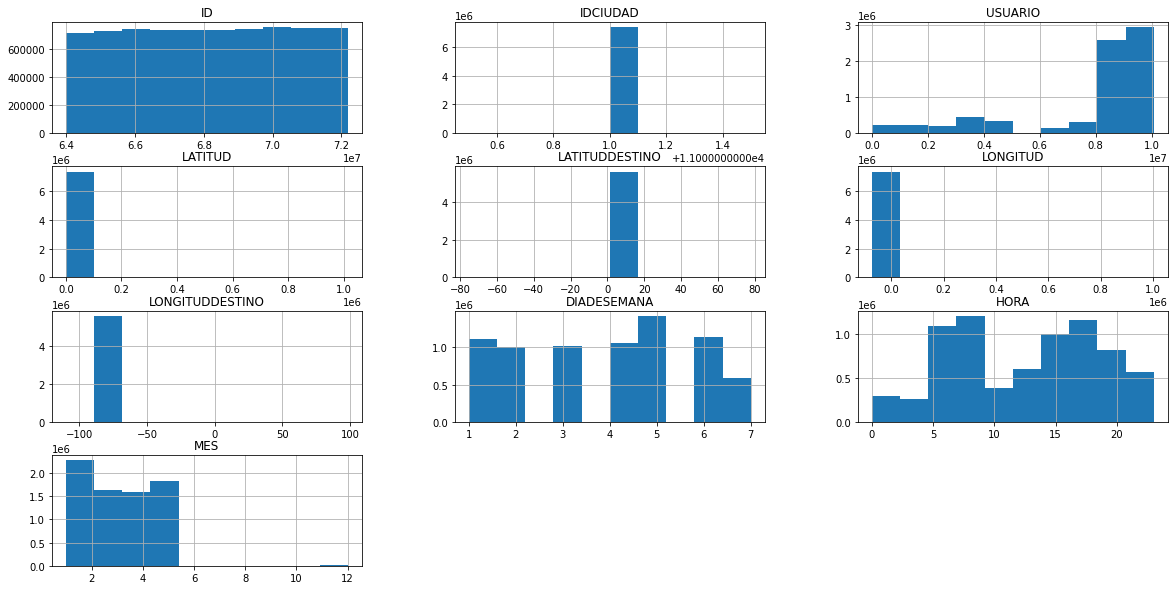

In [11]:
#Se require presentar gráfica de histograma por cada columna o datos de dataframe
df_taxis.hist(figsize=(20,10))
plt.show()

Se visualizan las corelaciones entre variables

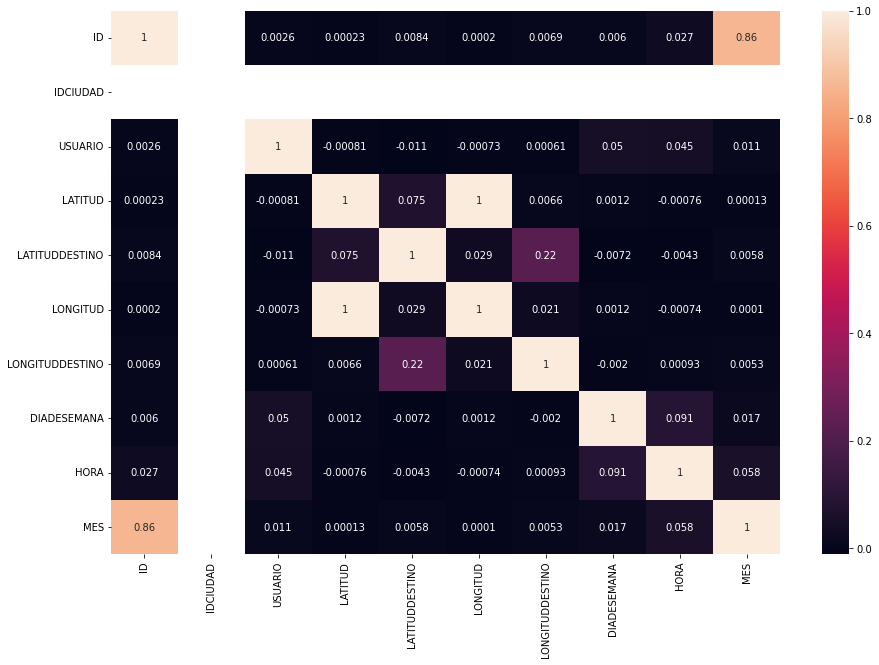

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(df_taxis.corr(method='pearson'),annot=True)

plt.show()

Se eliminan los datos que no se necesitan para predecir el modelo

In [13]:
#Eliminamos las columan que no son útiles para el modelo
df_taxis = df_taxis.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO"])
#Se eliminan los valores duplicados del dataframe y se ordenan por los campos más relevangtes
df_taxis = df_taxis.drop_duplicates().sort_values(by=['TELEFONOORIGEN','FECHA','DIADESEMANA','HORA'])
#Se reindexa nuevamente el dataFrame
df_taxis = df_taxis.reset_index(drop=True)
#Se visualizan como queda el dataFrame
df_taxis.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA,MES
0,+130047610,5,8,2022-04-29,4
1,+130055764,2,7,2022-04-12,4
2,+130055764,2,12,2022-04-12,4
3,+130153273,6,12,2022-02-05,2
4,+130153273,6,21,2022-05-28,5


Se contabilizan cuantos servicios tiene asignado un teléfono después de eliminar los duplicados

In [14]:
count_data = df_taxis.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3107584482        783
3138647901        684
3153865158        684
3134579964        642
13148180          628
                 ... 
3125329815          1
3125330004          1
3125330436          1
3125330453          1
999883673           1
Length: 517850, dtype: int64

Se observa la distribución de los datos

In [15]:
#Se visualizan los valores de los datos
count_data.describe()

count    517850.000000
mean          6.873261
std          15.002049
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max         783.000000
dtype: float64

Se calcula el outlayer de los datos

In [16]:
#Se calcula el quartil 25
q25 = count_data.quantile(0.25)
#Se calcula el quartil 75
q75 = count_data.quantile(0.75)
#Se calcula el rango inter quartil
iqr = q75 - q25

print(f"El porcentaje del quartil 25: {q25}")
print(f"El porcentaje del quartil 75: {q75}")
print(f"El rango inter quartil es: {iqr}")

El porcentaje del quartil 25: 1.0
El porcentaje del quartil 75: 6.0
El rango inter quartil es: 5.0


Se calcula el umbral de los valores atípicos

In [17]:
#Se calcula el umbral de los  valores atípicos
outliers_threshold = ( q75 + 3 * iqr )
print(f"El umbral de los valores atípicos es: {outliers_threshold}")
print(f"La cantidad de valores atípicos son: {sum(count_data > outliers_threshold) }")

El umbral de los valores atípicos es: 21.0
La cantidad de valores atípicos son: 36290


Eliminamos los datos que esten por debajo del umbral de los valores atípicos

In [18]:
df_cleaned = df_taxis.copy()
#Se descartan los que tienen menos del umbral de los valores atípicos
df_cleaned = df_cleaned.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > outliers_threshold)
#Se visualizan los datos agrupados por mes para determinar cuantos servicios tomó un usuario
df_cleaned.groupby(['MES','TELEFONOORIGEN'])['TELEFONOORIGEN'].count()

MES  TELEFONOORIGEN
1    0000000000        107
     12009954            6
     12013202           39
     12015158            2
     12029455            1
                      ... 
12   3508047744          1
     3508213441          2
     3508301213          1
     3508374630          2
     6051414             1
Name: TELEFONOORIGEN, Length: 169585, dtype: int64

In [19]:
#Se visualizan los valores de los datos
df_cleaned.loc[:,['TELEFONOORIGEN']].value_counts().describe()

count    36290.000000
mean        47.244172
std         34.939503
min         22.000000
25%         27.000000
50%         35.000000
75%         54.000000
max        783.000000
dtype: float64

In [20]:
#Se visualiza la cantidad de registros
df_cleaned.shape

(1714491, 5)

Transformamos el valor de origen y estado a no ordinales con onehot.

In [21]:
# convertimos a  onehot la comuna de origen
#df = pd.get_dummies(df, columns=["ORIGEN"])
# convertimos a  onehot la comuna de estado
#df = pd.get_dummies(df, columns=["ESTADO"])
"""new_df['ORIGEN'] = new_df['ORIGEN'].map( {
        "APP":1,
        "CALLE":2,
        "CHAT_BOT_659":3,
        "CHAT_BOT_689":4,
        "CHAT_BOT_729":5,
        "CHAT_BOT_803":6,
        "EXTERNO":7,
        "IONTAXI":8,
        "IVR":9,
        "NUEVO":10,
        "RECEPCION":11,
        "RED AMARILLA":12,
        "Reserva":13,
        "TELEGRAMTD":14,
        "WEB":15
    } )

new_df['ESTADO'] = new_df['ESTADO'].map( {
        "ABANDONADO":1,
        "ABORDOCONFIRMADO":2,
        "ALFRENTE":3,
        "ASIGNADO": 4,
        "CANCELADO":5,
        "CONFIRMADO":6,
        "CUMPLIDO":7,
        "FINALIZADO": 8,
        "LOCUCION":9,
        "NUEVO":10,
        "RECHAZADO":11
    } )"""
df_cleaned.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA,MES
68,0000000000,5,19,2021-12-31,12
69,0000000000,5,21,2021-12-31,12
70,0000000000,5,22,2021-12-31,12
71,0000000000,6,0,2022-01-01,1
72,0000000000,6,1,2022-01-01,1


### VISUALIZACIÓN DE DATOS

* Gráfico de dispersión de las variables
* Gráfico de distribución de las variables (Baja distribución, Baja predicción)
* Gráficas de correlación (Mapa de calor)

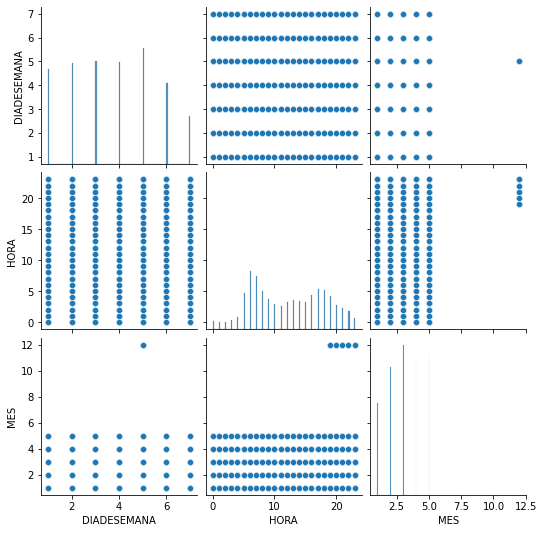

In [22]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_cleaned)
plt.show()

In [23]:
corr_matrix = df_cleaned.corr()
corr_matrix

,DIADESEMANA,HORA,MES
DIADESEMANA,1.000000,0.042726,0.017200
HORA,0.042726,1.000000,0.012006
MES,0.017200,0.012006,1.000000


Text(0.5, 69.0, 'X')

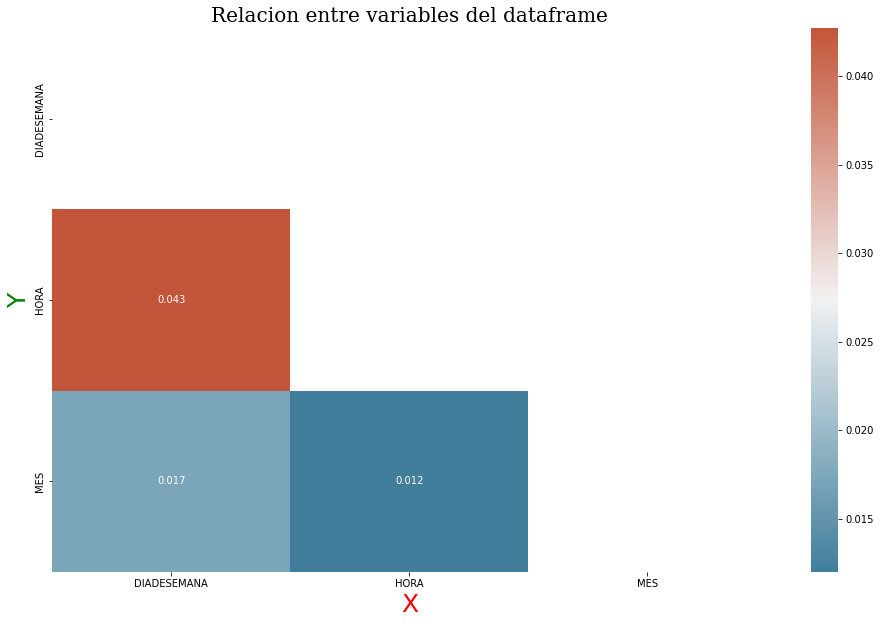

In [24]:
f, ax = plt.subplots(figsize=(16, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap )
plt.title('Relacion entre variables del dataframe',fontsize=20,fontname='serif')
plt.ylabel('Y', color='green', fontsize=25)
plt.xlabel('X', color='Red', fontsize=25)

### EXPERIMENTOS CON DIFERENTES ENTRENAMIENTOS

In [25]:
#Función que permite identificar si en una fila hay un registro en la hora y en el día
def findRow(pdate, phour, data):
  for row in data:
    if( ( row[3] == pdate.strftime(FORMAT_DATE) ) & ( row[2] == phour ) ):
      return row
  return []

In [26]:
#Funcion para llenar los servicios no tomados con 0
def preparingDataService(data, from_date, to_date, phone):
  #first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  #last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  
  first = to_date
  last = from_date

  count = 0
  total = 0

  remaining_days = first.date() - last.date()
  data_array = data.to_numpy()
  new_array = []
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    for day in range(HOURS_OF_DAY):
      new_row = findRow(last_time.date(), day, data_array)
      total += 1
      if len(new_row) > 0:
        new_array.append(np.append(new_row, 1))
        count += 1
      else:
        new_array.append([phone, last_time.isoweekday(),day,last_time.date().strftime(FORMAT_DATE),last_time.date().month,0])
  #col = data.columns
  #print(type(col))
  #for col in data.columns:
  #  print(col)
  print(f"Cantidad de valores positivos: {count}, total registros: {total}")
  return pd.DataFrame(new_array, 
             columns=['TELEFONOORIGEN', 
                      'DIADESEMANA', 'HORA','FECHA','MES','SERVICIO'])

In [27]:
#limites de decision
def make_meshgrid(X, step=.02):
    x = X.iloc[:,0].values
    y = X.iloc[:,1].values
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    return xx, yy

def plot_contours(ax, clf, X, y, **params):

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'cyan', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    xx, yy = make_meshgrid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        Z[Z == cl] = idx
        ax.scatter(X.loc[y == cl, X.columns[0]], 
                    X.loc[y == cl, X.columns[1]],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl, 
                    edgecolor='black',
                    cmap=cmap,
                    s=50)
    
    ax.legend()
    ax.set_ylabel(X.columns[1])
    ax.set_xlabel(X.columns[0])
    ax.set_title(clf.__class__.__name__)
    ax.grid()    
    out = ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
    
    return out

In [28]:
#ROC Y AUC
def ROC(X, y, model):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

  clf = OneVsRestClassifier(model)
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  pred_prob = clf.predict_proba(X_test)
  pred_prob = np.nan_to_num(pred_prob)

  fpr = {}
  tpr = {}
  thresh ={}

  fig, ax = plt.subplots(figsize=(10,8))
  colors = ('orange', 'green', 'blue')
  
  for index, label_ in enumerate(y.unique()):
    fpr[label_], tpr[label_], thresh[label_] = roc_curve(y_test, pred_prob[:,index], pos_label=label_) 
    ax.plot(fpr[label_], tpr[label_], linestyle='--',color=colors[index], label=label_)
  
  ax.plot([0, 1], [0, 1], linestyle='--',color='red', label='No Skill')
  ax.set_title(f'Multiclass ROC curve -  {model.__class__.__name__}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive rate')
  ax.grid(True)
  plt.show()

  return ax.legend(loc='best')

Función que permite evaluar el modelo de la regresión logística

In [29]:
def knnModel(X_train, y_train, X_test):
    #Selección del modelo
    model = KNeighborsClassifier(n_neighbors=3)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [30]:
def mlpModel(X_train, y_train, X_test):
    #Selección del modelo
    model = MLPClassifier(max_iter=20000) #(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,30, 30), random_state=1,learning_rate_init=0.001,max_iter=200)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

Función que permite evaluar el modelo del arbol de desición

In [31]:
def lrModel(X_train, y_train, X_test):
    #Selección del modelo
    model = LogisticRegression(random_state = 1)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [32]:
def rfModel(X_train, y_train, X_test):
    #Selección del modelo
    model = RandomForestClassifier(random_state=1, max_depth=4)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [33]:
def svcModel(X_train, y_train, X_test):
    #Selección del modelo
    model = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [34]:
def dtcModel(X_train, y_train, X_test,):
    #Selección del modelo
    model = DecisionTreeClassifier(criterion='gini', max_depth=12, random_state=1, class_weight={0: 1, 1: 5})
    #A Continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para entrenamiento y pruebas
    y_pred = model.predict(X_test)
    #ypred = model.predict_proba(X_test)
    return model, y_pred

In [35]:
def dataVisualization(df_train):
    #Se visualiza los datos por columnas de entrenamiento
    fig, axes = plt.subplots(1, len(df_train.columns))
    fig.set_size_inches(21,6)
    for i, column in enumerate(df_train.columns):
        sns.histplot(df_train[column], kde=True, ax=axes[i])
    plt.show()

In [68]:
def confusionMatrix(model, y_test, y_pred):
  '''
  plt.rcParams.update({'font.size': 16})
  fig, axes = plt.subplots(figsize=(14, 10))
  disp = ConfusionMatrixDisplay.from_estimator(model,
                                             y_test,
                                             y_pred,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues,
                                             ax=axes
                                             )
  disp.ax_.set_title(f'Confusion Matrix - {model.__class__.__name__}')
  plt.show()
  '''
  plt.rcParams.update({'font.size': 16})
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
  
  disp.plot()
  plt.show()


In [37]:
def contoursGrap(model, X, y):
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(figsize=(12, 10))
    plot_contours(axes, model, X, y, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.show()

In [240]:
def reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type):
    if model_type == 'LR':
        #Se imprimen los coeficientes, intresección y número de coeficientes
        print(f"Coeficientes del modelo: {model.coef_}\n")
        print(f"Intresección del modelo: {model.intercept_}\n")
        print(f"Número de coeficientes del modelo: {len(model.coef_)}\n")
    #mae = mean_absolute_error(y_pred, y_train)
    #print("MAE:",(mae))

    #print(f"Variable de predicción: {y_pred}\n")
    #print(classification_report(y_train, y_pred))
    if model_type != 'PR':

        if model_type != 'SVC':
            #
            ROC(X_train, y_train, model)
        #
        contoursGrap(model, X_train, y_train)
    #
    confusionMatrix(model, y_test, y_pred)
    

In [39]:
def calculateProbability(hour, day, data):
  data_array = data.to_numpy()

  first = pd.to_datetime(data.tail(1).iloc[0,2], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,2], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()
  #print("First:",first,", last:",last,", remaining:",remaining_days)
  total = 0 
  for i in range(remaining_days.days):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  
  total_onset = 0
  for row in data_array:
    if( ( row[0] == day ) & ( row[1] == hour ) & ( row[3] == 1 ) ):
      total_onset += 1
  
  #print("Total:",total,",Total onset:",total_onset)
  if total > 0:
    return total_onset / total
  else:
    return 0

In [161]:
def calculateProbabilisticModel(data, date_predict):
    array_prob = []
    for hour in range(HOURS_OF_DAY):
        prob = calculateProbability(hour, date_predict.isoweekday(), data)
        array_prob.append(1 if prob >= 0.5 else 0)
    return array_prob

In [251]:
#Función que entrene el modelo y nos devuelva el y_predicted
def evaluate_model(phone, data, date_predict, model_type):
  #Se filtra por el número de teléfono
  data = data[data["TELEFONOORIGEN"]==phone].copy()
  
  #Se obtiene la fecha de inicial de entrenamiento
  date_first_training = date_predict - timedelta(weeks=NUM_OF_WEEK)
  #Se obtiene la fecha de final del entrenamiento
  date_last_training = date_predict + timedelta(weeks=1)
  #Se obtiene la fecha de inicial de entrenamiento de y
  #y_date_first_training = date_predict - timedelta(weeks=1)
  
  #Se particiona el dataframe desde la fecha inicial y hasta la fecha final de entrenamiento
  data = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < date_last_training) ]
  data = preparingDataService(data, date_first_training, date_last_training, phone)
  #Se elimina el teléfono debido a que no es relevante para el modelo
  data = data.drop(labels=['TELEFONOORIGEN'], axis=1)
  
  #Se crear el dataframe de entrenamiento desde la fecha inicial hasta la fecha de predicción
  train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < date_predict) ]
  #Se crear el dataframe de pruebas desde la fecha de predicción hasta una semana adelante
  test = data[(pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_predict) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < date_last_training) ]
  
  #Datos para probar los modelos
  train = train.loc[:,['DIADESEMANA','HORA','SERVICIO']]
  test = test.loc[:,['DIADESEMANA','HORA','SERVICIO']]

  y_train = train.SERVICIO
  X_train = train.drop(labels='SERVICIO', axis=1)

  y_test = test.SERVICIO
  X_test = test.drop(labels='SERVICIO', axis=1)

  y_pred = []
  if model_type == 'LR':
    #Se visualiza los datos
    dataVisualization(train)
    model, y_pred = lrModel(X_train, y_train, X_test)
    print(f"model: {type(model.classes_)}")
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'KNN':
    model, y_pred = knnModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'MLP':
    model, y_pred = mlpModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'RF':
    model, y_pred = rfModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'SVC':
    model, y_pred = svcModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'DTC':
    model, y_pred = dtcModel(X_train, y_train, X_test)
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  elif model_type == 'PR':
    
    remaining_days = date_last_training.date() - date_predict.date()
    y_calculate = []
    for d in range(remaining_days.days):
      last_predict = date_predict + timedelta(days=d)
      train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < last_predict) ]
      test = data[(pd.to_datetime(data['FECHA'], format=FORMAT_DATE) == date_predict)]
      y_calculate.append(calculateProbabilisticModel(train, last_predict))
    
    y_pred = np.empty(0,dtype=int)
    for i in y_calculate:
      for j in i:
        y_pred = np.append(y_pred, int(j))

    class model:
      classes_ = np.empty(0,dtype=int)
    model.classes_ = np.array([0, 1])
    reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
  else:
    print("Modelo no existe!")
    return

  return y_pred, y_test

Se crea un nuevo dataFrame con los números de teléfonos para recorrer los modelos

In [165]:
#Se crea un nuevo dataframe con los teléfonos para entrenar cada usuario personalizado
df_phone = df_cleaned.loc[:,['TELEFONOORIGEN']].copy()
df_phone = df_phone.drop_duplicates().sort_values(by=['TELEFONOORIGEN'])
df_phone = df_phone.reset_index(drop=True)
phone_array = df_phone[df_phone["TELEFONOORIGEN"]=="3115590650"].to_numpy()
df_phone = NaN

# Evaluación de los modelos

Experimento con el modelo probábilistico

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


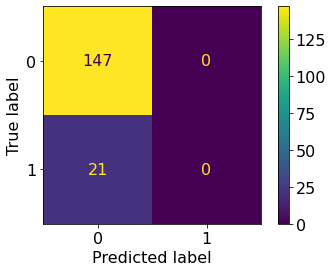

In [252]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'PR')

Experimento con el modelo de regresión logistica

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 130, total registros: 1536


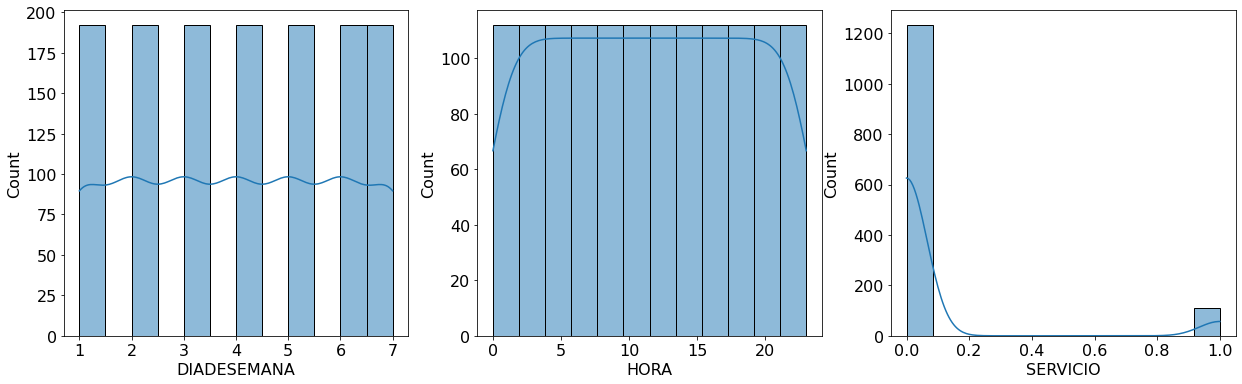

model: <class 'numpy.ndarray'>
Coeficientes del modelo: [[-0.17302387  0.15386263]]

Intresección del modelo: [-3.95200588]

Número de coeficientes del modelo: 1



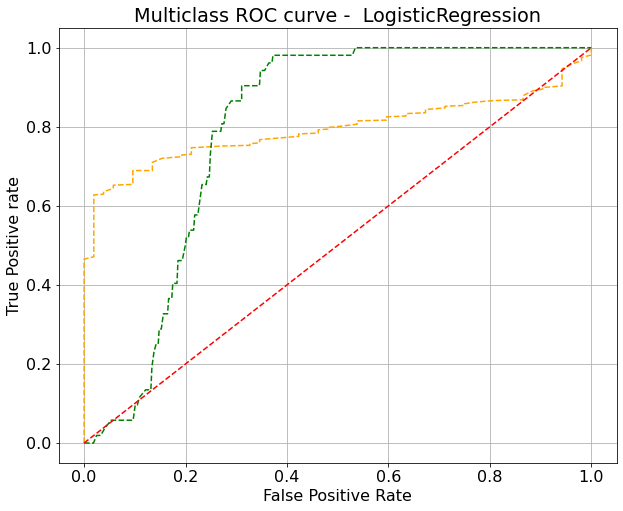

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


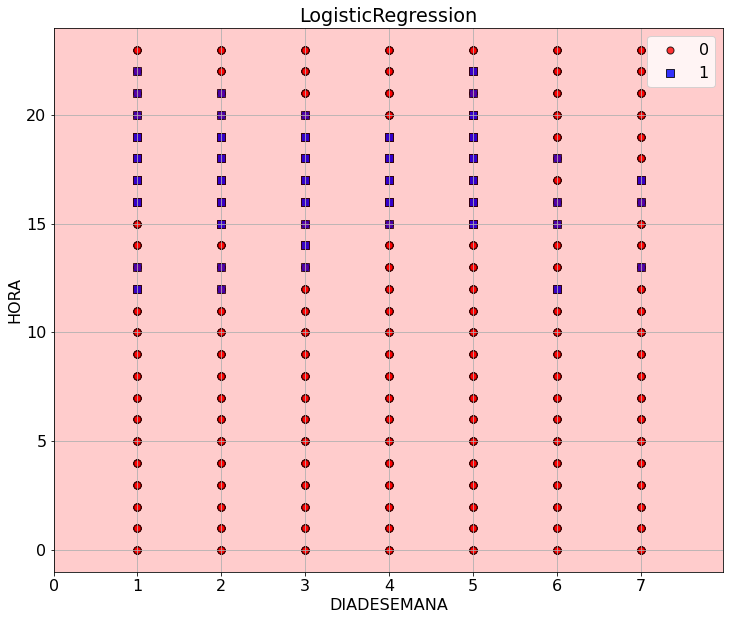

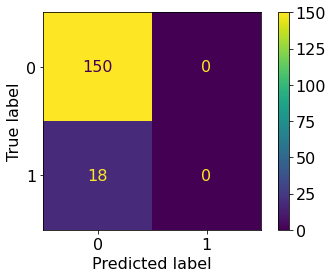

In [253]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-24", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'LR')

Experimento con el modelo de KNN

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 0, total registros: 1536


c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(


AttributeError: 'DataFrame' object has no attribute 'unique'

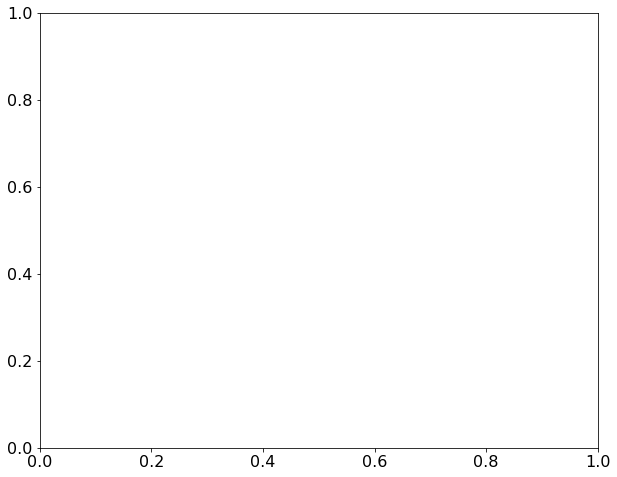

In [197]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'KNN')

Experimento con el modelo de perceptron multicapa

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


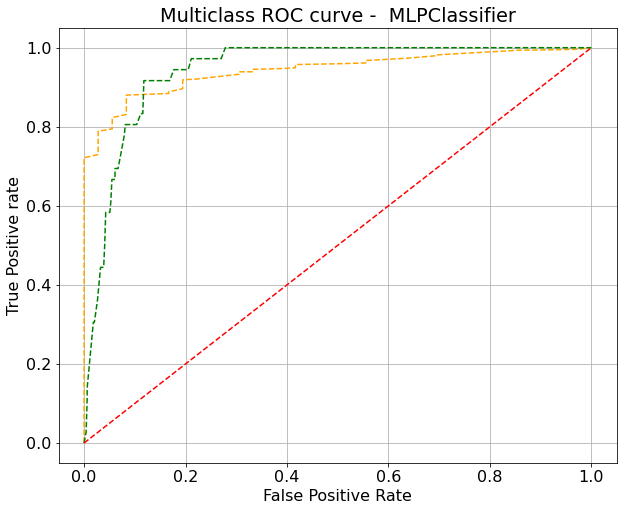

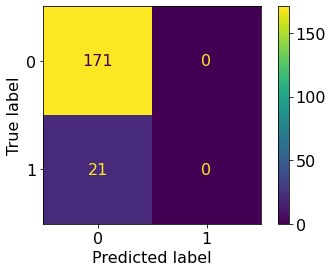

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


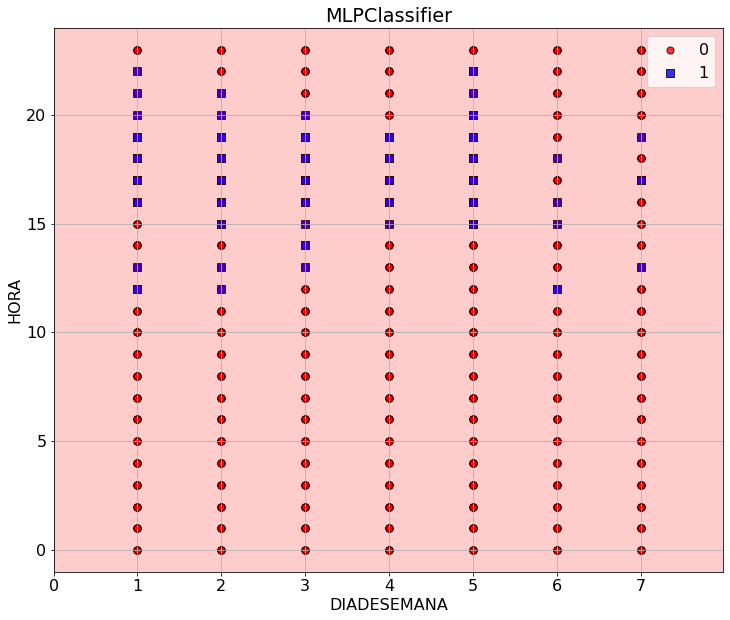

In [70]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'MLP')

Experimento con el modelo de arboles aleatorios

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


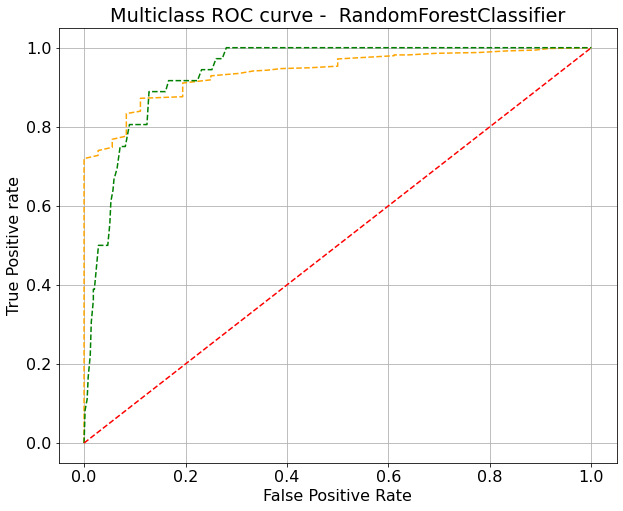

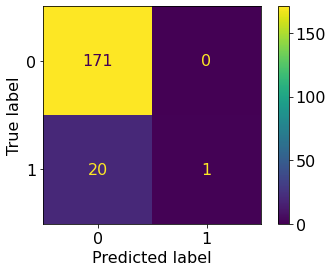

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


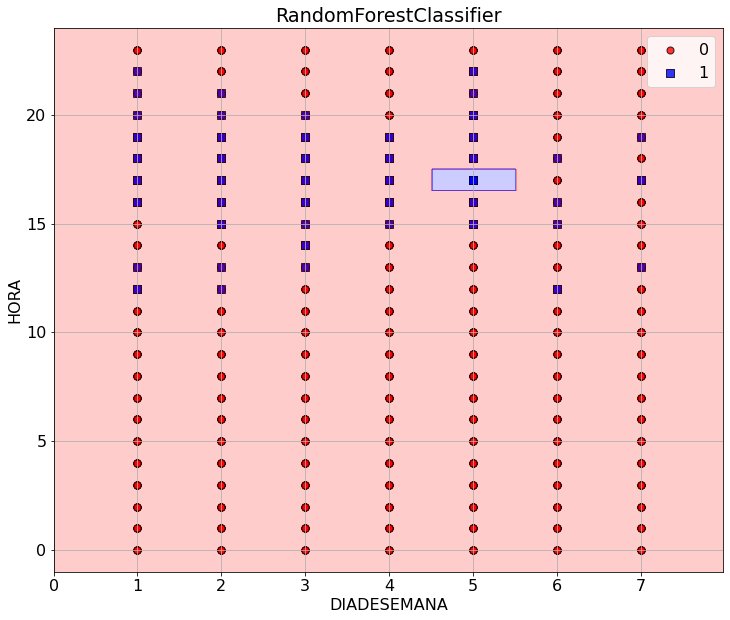

In [71]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'RF')

Experimento con el modelo de clsasificacón con máquina de vector de soporte

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


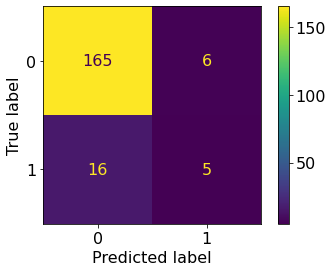

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


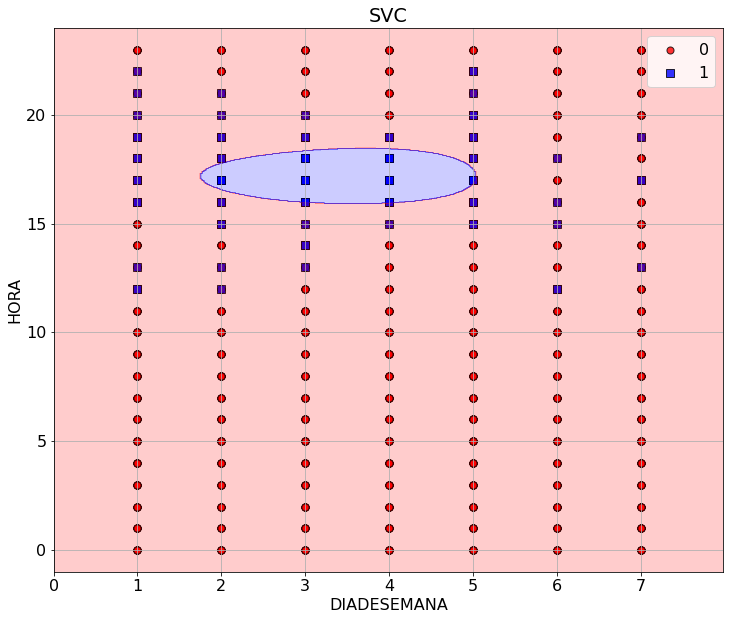

In [72]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'SVC')

Experimento con el modelo de clsasificacón con arboles de decisión

Procesando el teléfono: 3115590650
Cantidad de valores positivos: 136, total registros: 1536


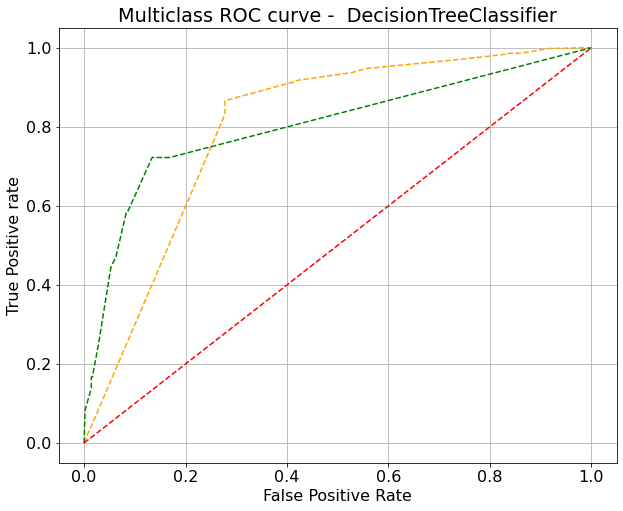

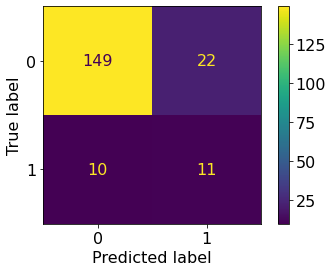

c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


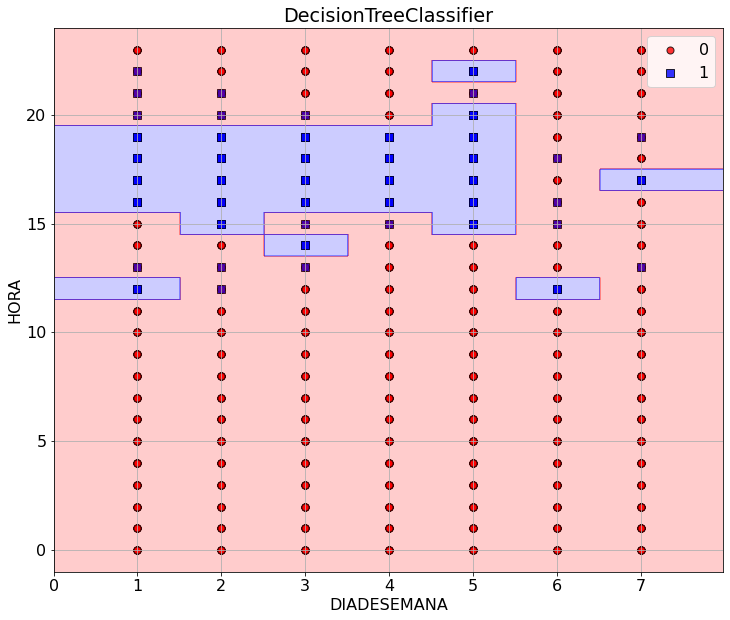

In [74]:
DATE_START_TRAINIG = pd.to_datetime("2022-04-27", format=FORMAT_DATE)
for data_row in phone_array:
    print(f"Procesando el teléfono: {data_row[0]}")
    y_pred, ytest = evaluate_model(data_row[0], df_cleaned, DATE_START_TRAINIG, 'DTC')